In [1]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import time
import pandas as pd
import cv2
import random
import numpy as np
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

---

### Image to CSV

In [95]:
label_dict = {
    "T-shirt/top":0,
    "Trouser":1,
    "Pullover":2,
    "Dress":3,
    "Coat":4,
    "Sandal":5,
    "Shirt":6,
    "Sneaker":7,
    "Bag":8,
    "Ankle_boot":9
}

In [76]:
# 원하는 Label number 리스트로 담기
file_path = './datasets/test_label.txt'

is_target = [False for _ in range(10)]
target_label = [6] # 증강할 Label 담기 0, 2, 6
for i in target_label:
    is_target[i] = True
target_res = [[] for _ in range(10)]

with open(file_path, 'r') as file:
    for line in file:
        num, label = map(int, line.split())
        if is_target[label]:
            target_res[label].append(num)

In [91]:
augmented_size = 1 # 클래스별 증강할 개수
for label in target_label:
    random_nums = random.sample(target_res[label], augmented_size)
    for num in random_nums:
        origin_image = cv2.imread(f'./datasets/public_test_dataset/{num:0>5d}.png')
        cv2.imwrite('origin_image.jpg', origin_image)
        resized_image= cv2.resize(image, (28, 28),fx=0.6, fy=0.6)
        cv2.imwrite('resized_image.jpg', resized_image)


In [14]:
IMAGE_NUM = 10000
IMAGE_DIM = 784
save_arr = np.empty((1, IMAGE_DIM), dtype='int64')
for image_ind in range(IMAGE_NUM):
    image = np.array(cv2.imread(f"./datasets/public_test_dataset/{image_ind:0>5d}.png", cv2.IMREAD_GRAYSCALE)) # 경로는 각자 수정
    image = image.reshape(1, IMAGE_DIM)
    save_arr = np.r_[save_arr, image]
save_arr = np.delete(save_arr, 0 , axis = 0) #Dummy row 삭제
print(save_arr.shape)

(10000, 784)


In [15]:
df = pd.DataFrame(save_arr)
df.to_csv('public_test_data.csv', index=False)


---


### Image Augmentation

In [17]:
train = pd.read_csv('fashionmnist/fashion-mnist_train.csv')
test = pd.read_csv('fashionmnist/fashion-mnist_test.csv')

In [20]:
df_train = train.copy()
df_test = test.copy()

In [51]:
X_train= df_train.drop(['label'],axis = 1)
X_test = df_train['label']
y_test = df_test.drop(['label'],axis = 1)

X_train = X_train.astype('float32')
y_test = y_test.astype('float32')
X_train /= 255.0
y_test /=255.0

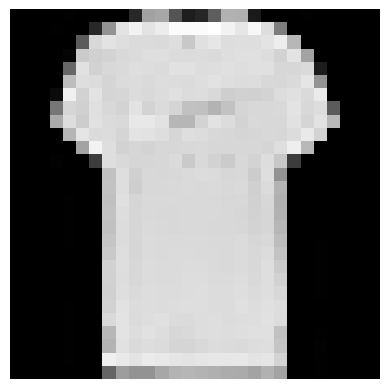

(100, 28, 28, 1)


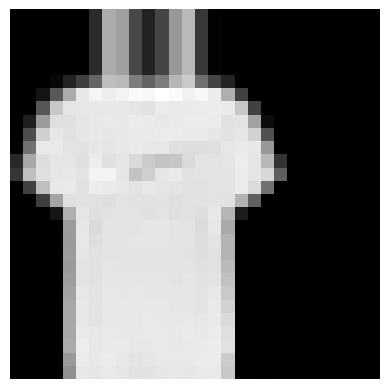

In [57]:
origin_train = X_train.values # pandas.DF -> numpy.ARRAY
origin_train = origin_train.reshape(-1, 28, 28, 1) # 28x28로 변환
plt.imshow(origin_train[10], cmap='gray')
plt.axis('off')  # 축을 표시하지 않음
plt.show()
image_generator = ImageDataGenerator(
            rotation_range=0,       # 회전 범위
            zoom_range=0.30,        # 확대/축소 범위
            shear_range=0,          # 변형(전단) 범위
            width_shift_range=0.17, # 가로 이동 범위
            height_shift_range=0.217,# 세로 이동 범위
            horizontal_flip=False,  # 수평 뒤집기
            vertical_flip=False)    # 수직 뒤집기

augment_size = 100 # 증강할 이미지 개수

#flow는 보강된 이미지를 생성하는 함수
x_augmented = image_generator.flow(np.tile(origin_train[10].reshape(28*28),100).reshape(-1,28,28,1), np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]
print(x_augmented.shape)  # 증강된 이미지 데이터의 형태 출력
plt.imshow(x_augmented[0], cmap='gray')
plt.axis('off')  # 축을 표시하지 않음
plt.show()

In [31]:
seed = 99
np.random.seed(seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, X_test, test_size=0.1, random_state = seed)

In [32]:
pca = PCA(n_components=400)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_val)
y_test_pca = pca.transform(y_test)

X_train_PCA1 = pd.DataFrame(X_train_pca)
X_test_PCA1 = pd.DataFrame(X_test_pca)

<class 'pandas.core.frame.DataFrame'>


In [11]:
xgb = XGBClassifier(
    n_estimators=80,  # 트리의 개수 (많을수록 오버피팅)
    learning_rate=0.3,  # 학습률 (값이 작을수록 모델이 안정 수렴함)
    max_depth=4,  # 트리의 최대 깊이 (깊을수록 오버피팅)
    subsample= 1.0,  # 훈련 데이터의 사용률(1.0이 최대)
    colsample_bytree=0.9,  # 각 트리를 훈련할 때 사용할 특성의 비율(1.0이 최대)
    gamma=1,  # 최소 손실 감소 값 (값이 클수록 보수적인 분할)
    n_jobs=-1,  # 병렬 처리에 사용할 CPU 코어의 수 (-1 == 사용가능한 최대 코어수)
    random_state=42  # 난수 생성기의 시드
)

In [31]:
rnd = RandomForestClassifier(
    n_estimators = 64, # 예측기 500개
    n_jobs = -1 # CPU 코어 구동 개수
) #max_leaf_nodes = 16, # 자식노드의 최대 개수 
#model = RandomForestClassifier(n_estimators=64, n_jobs=-1) # 0.8827, 29 seconds
# model = MLPClassifier(max_iter=700) # 0.8557, 190 seconds
svc = SVC(gamma='scale',kernel='rbf',C=8, probability=True) #probability=True 이거 없으면 soft voting 불가함 근데 시간 오래걸림

In [32]:
voting_clf = VotingClassifier(
    estimators=[('svc', svc), ('rnd', rnd)],
    voting='soft'
)

In [37]:
svc.fit(X_train_PCA1,y_train)
rnd.fit(X_train_PCA1, y_train.values.ravel())
voting_clf.fit(X_train_PCA1, y_train)

VotingClassifier(estimators=[('svc', SVC(C=8, probability=True)),
                             ('rnd',
                              RandomForestClassifier(n_estimators=64,
                                                     n_jobs=-1))],
                 voting='soft')

In [15]:
# xgb_train = xgb.predict(X_train_PCA1)
# xgb_pred = xgb.predict(X_test_PCA1)

In [38]:
#훈련 데이터 예측
svc_train = svc.predict(X_train_PCA1)
rnd_train = rnd.predict(X_train_PCA1)
voting_train = voting_clf.predict(X_train_PCA1)

#Test 데이터 예측
svc_pred = svc.predict(X_test_PCA1)
rnd_pred = rnd.predict(X_test_PCA1)
voting_pred = voting_clf.predict(X_test_PCA1)

In [39]:
svc_train_score = accuracy_score(y_train, svc_train)
svc_pred_score = accuracy_score(y_val, svc_pred)

print("----SVC----")
print("Train Accuracy score: {}".format(svc_train_score))
print("Test Accuracy score: {}".format(svc_pred_score))
print(classification_report(y_val, svc_pred))

----SVC----
Train Accuracy score: 0.9763333333333334
Test Accuracy score: 0.9101666666666667
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       574
           1       0.99      0.99      0.99       596
           2       0.83      0.84      0.84       573
           3       0.91      0.94      0.93       624
           4       0.86      0.86      0.86       635
           5       0.99      0.96      0.98       632
           6       0.77      0.73      0.75       600
           7       0.94      0.97      0.96       604
           8       0.97      0.98      0.98       598
           9       0.97      0.96      0.97       564

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



In [21]:
# XGB_train_score = accuracy_score(y_train, xgb_train)
# XGB_pred_score = accuracy_score(y_val, xgb_pred)

# print("----XGB----")
# print("Train Accuracy score: {}".format(XGB_train_score))
# print("Test Accuracy score: {}".format(XGB_pred_score))
# print(classification_report(y_val, xgb_pred))

----XGB----
Train Accuracy score: 0.9493148148148148
Test Accuracy score: 0.8765
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       574
           1       0.99      0.97      0.98       596
           2       0.78      0.79      0.79       573
           3       0.89      0.90      0.90       624
           4       0.82      0.80      0.81       635
           5       0.96      0.93      0.94       632
           6       0.69      0.65      0.67       600
           7       0.92      0.95      0.94       604
           8       0.95      0.97      0.96       598
           9       0.95      0.96      0.95       564

    accuracy                           0.88      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000



In [40]:
rnd_train_score = accuracy_score(y_train, rnd_train)
rnd_pred_score = accuracy_score(y_val, rnd_pred)

print("----RND----")
print("Train Accuracy score: {}".format(rnd_train_score))
print("Test Accuracy score: {}".format(rnd_pred_score))
print(classification_report(y_val, rnd_pred))

----RND----
Train Accuracy score: 1.0
Test Accuracy score: 0.8593333333333333
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       574
           1       0.99      0.96      0.98       596
           2       0.74      0.78      0.76       573
           3       0.88      0.89      0.89       624
           4       0.78      0.80      0.79       635
           5       0.93      0.92      0.93       632
           6       0.69      0.57      0.63       600
           7       0.92      0.92      0.92       604
           8       0.94      0.95      0.94       598
           9       0.92      0.95      0.94       564

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000



In [41]:
voting_train_score = accuracy_score(y_train, voting_train)
voting_pred_score = accuracy_score(y_val, voting_pred)

print("----VOTING(앙상블)----")
print("Train Accuracy score: {}".format(voting_train_score))
print("Test Accuracy score: {}".format(voting_pred_score))
print(classification_report(y_val, voting_pred))

----VOTING(앙상블)----
Train Accuracy score: 0.9924444444444445
Test Accuracy score: 0.9096666666666666
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       574
           1       0.99      0.99      0.99       596
           2       0.85      0.84      0.84       573
           3       0.91      0.94      0.93       624
           4       0.86      0.86      0.86       635
           5       0.99      0.96      0.97       632
           6       0.76      0.74      0.75       600
           7       0.95      0.97      0.96       604
           8       0.97      0.98      0.97       598
           9       0.97      0.96      0.97       564

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000

